## Importamos data

In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from malbecs.modeling import train as tr


import warnings
warnings.filterwarnings('ignore')

wine_path = "../../data/final/wine_final.csv"
eto_path = "../../data/final/eto_final.csv"
meteo_path = "../../data/final/meteo_final.csv"

def show_feat_imps(feat_imp, feat_names):
    pd.DataFrame(
        feat_imp,
        index=feat_names,
        columns=["feat_imp"]
    ).sort_values("feat_imp")[-50:].plot(kind='barh', figsize=(6, 15))


In [303]:

data = tr.load_final_data(
    wine_path=wine_path,
    eto_path=eto_path,
    meteo_path=meteo_path
)

with open("../../data/final/meteo_features.txt", "r", encoding="utf-8") as f:
    meteo_cols = f.read().split("\n")

with open("../../data/final/eto_features.txt", "r") as f:
    eto_cols = f.read().split("\n")

with open("../../data/final/wine_features.txt", "r") as f:
    wine_cols = f.read().split("\n")


Split train

In [304]:
data_train = tr.filter_camp(data.copy(), min_camp=15, max_camp=21)

data_final = tr.filter_camp(data, min_camp=22, max_camp=22)

train, test = tr.train_test_split(data_train, test_camp=21)

X, y = tr.xy_split(data_train)

cat_cols = [
    'id_finca',
    'id_zona',
    'id_estacion',
    'variedad',
    "modo",
    "tipo",
    "color",
    "prod_shift1_gt_shift2",
    "sup_is_nan",
]
num_cols = [col for col in X.columns if col not in cat_cols]

X[cat_cols] = X[cat_cols].astype('category')

X_train, y_train = tr.xy_split(train)
X_test, y_test = tr.xy_split(test)
X_final, y_final = tr.xy_split(data_final)

train_idxs, test_idxs = tr.CampKFold.get_train_test(
    X['campaña'], from_camp=19, to_camp=21
)

cv = tr.CampKFold(train_idxs, test_idxs)


## Nuevas features post meet

#### Agregar a Exploracion?

Variacion de produccion anual segun variedades

In [187]:
data_train.variedad.nunique()

25

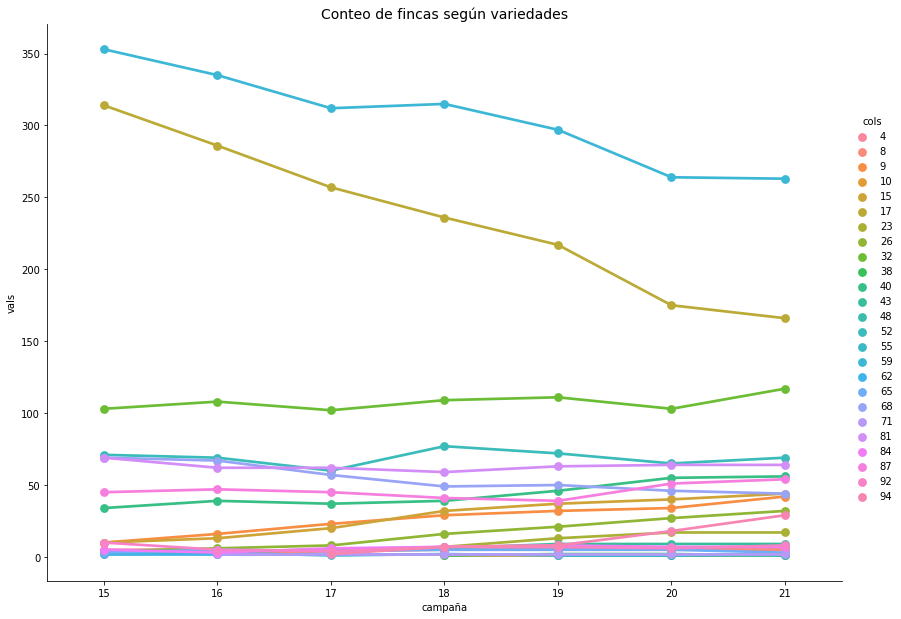

In [182]:
df_variedades = data_train.groupby(['campaña','variedad']).agg({'produccion':'count'}).unstack()

df_variedades = (df_variedades
                 .droplevel(0, axis=1)
                 .reset_index()
                 .melt('campaña', var_name='cols', value_name='vals'))

import seaborn as sns

sns.catplot(x="campaña", y="vals", hue='cols', data=df_variedades, kind='point', height=8.27, aspect=11.7/8.27)
plt.title('Conteo de fincas según variedades', fontsize=14)
plt.show()


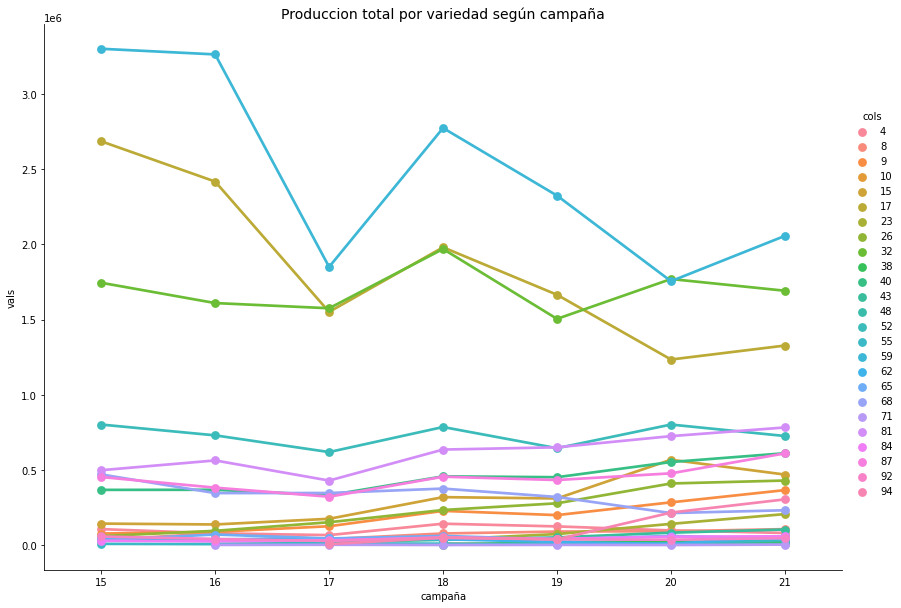

In [197]:
df_variedades = data_train.groupby(['campaña','variedad']).agg({'produccion':'sum'}).unstack()

df_variedades = (df_variedades
                 .droplevel(0, axis=1)
                 .reset_index()
                 .melt('campaña', var_name='cols', value_name='vals'))

import seaborn as sns

sns.catplot(x="campaña", y="vals", hue='cols', data=df_variedades, kind='point', height=8.27, aspect=11.7/8.27)
plt.title('Produccion total por variedad según campaña', fontsize=14)
plt.show()


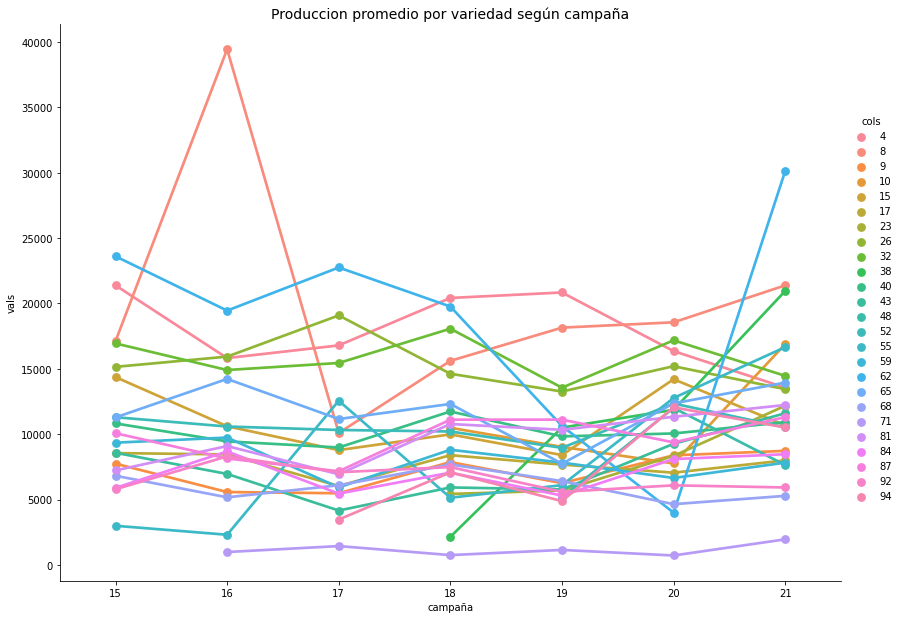

In [198]:
df_variedades = data_train.groupby(['campaña','variedad']).agg({'produccion':'mean'}).unstack()

df_variedades = (df_variedades
                 .droplevel(0, axis=1)
                 .reset_index()
                 .melt('campaña', var_name='cols', value_name='vals'))

import seaborn as sns

sns.catplot(x="campaña", y="vals", hue='cols', data=df_variedades, kind='point', height=8.27, aspect=11.7/8.27)
plt.title('Produccion promedio por variedad según campaña', fontsize=14)
plt.show()


Variacion de produccion anual segun estacion

In [202]:
data_train.id_estacion.nunique()

19

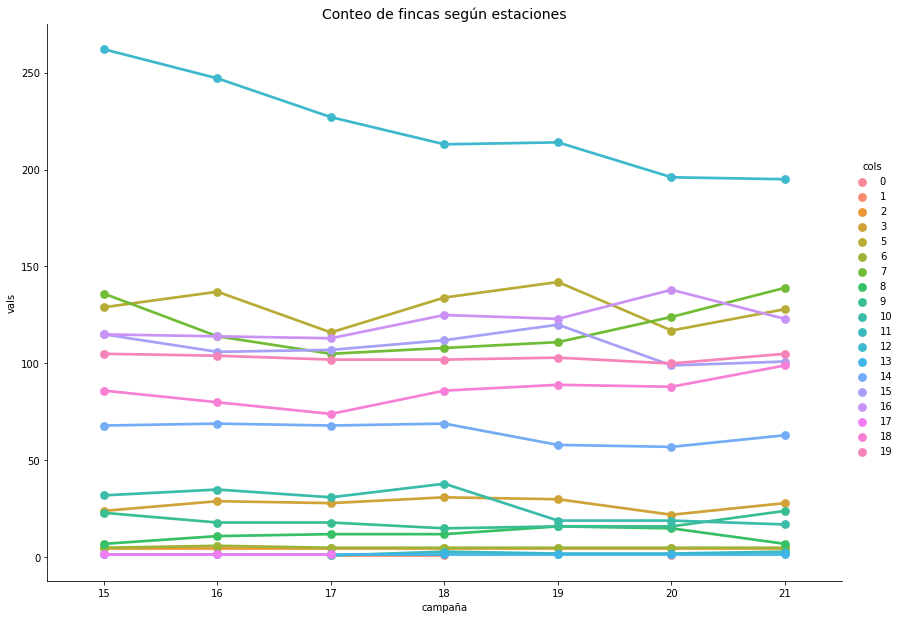

In [190]:
df_estaciones = data_train.groupby(['campaña','id_estacion']).agg({'produccion':'count'}).unstack()

df_estaciones = (df_estaciones
                 .droplevel(0, axis=1)
                 .reset_index()
                 .melt('campaña', var_name='cols', value_name='vals'))

import seaborn as sns

sns.catplot(x="campaña", y="vals", hue='cols', data=df_estaciones, kind='point', height=8.27, aspect=11.7/8.27)
plt.title('Conteo de fincas según estaciones', fontsize=14)
plt.show()


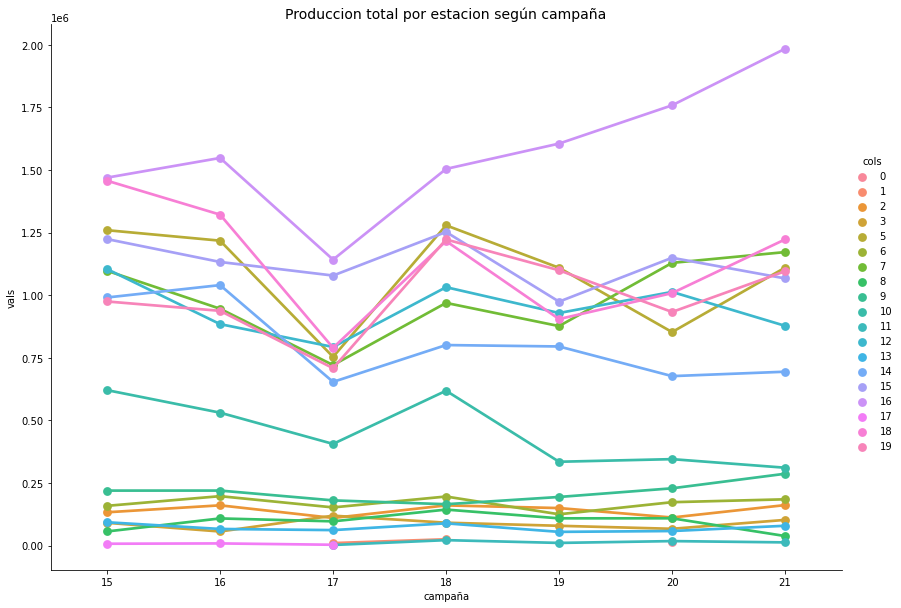

In [199]:
df_estaciones = data_train.groupby(['campaña','id_estacion']).agg({'produccion':'sum'}).unstack()

df_estaciones = (df_estaciones
                 .droplevel(0, axis=1)
                 .reset_index()
                 .melt('campaña', var_name='cols', value_name='vals'))

import seaborn as sns

sns.catplot(x="campaña", y="vals", hue='cols', data=df_estaciones, kind='point', height=8.27, aspect=11.7/8.27)
plt.title('Produccion total por estacion según campaña', fontsize=14)
plt.show()


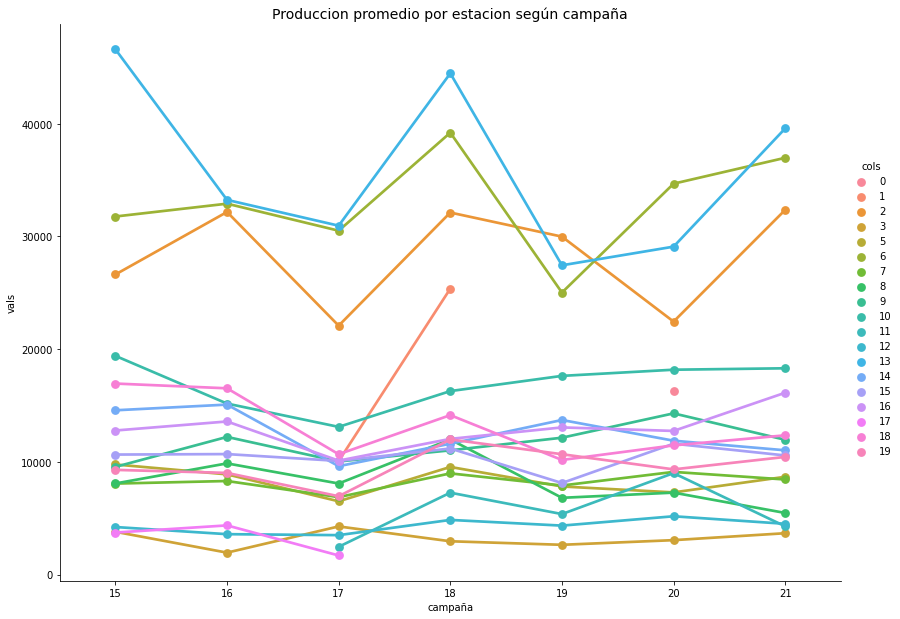

In [201]:
df_estaciones = data_train.groupby(['campaña','id_estacion']).agg({'produccion':'mean'}).unstack()

df_estaciones = (df_estaciones
                 .droplevel(0, axis=1)
                 .reset_index()
                 .melt('campaña', var_name='cols', value_name='vals'))

import seaborn as sns

sns.catplot(x="campaña", y="vals", hue='cols', data=df_estaciones, kind='point', height=8.27, aspect=11.7/8.27)
plt.title('Produccion promedio por estacion según campaña', fontsize=14)
plt.show()



### Modelos con fases climaticas 

Fases climaticas: https://utielrequena.org/la-brotacion-la-vendimia-las-fases-del-ciclo-la-vid/

In [206]:
from malbecs.preprocess import eto as eto_pr
from malbecs.feateng import eto as eto_fe

raw_eto_path = '../../data/raw/DATOS_ETO.TXT'

eto_data = eto_pr.load_eto_dataset(raw_eto_path)

In [207]:
avg_cols = [
    'DewpointLocalDayAvg',
    'EvapotranspirationLocalDayAvg',
    'FeelsLikeLocalDayAvg',
    'GlobalHorizontalIrradianceLocalDayAvg',
    'GustLocalDayAvg',
    'MSLPLocalDayAvg',
    'PrecipAmountLocalDayAvg',
    'RelativeHumidityLocalDayAvg',
    'SnowAmountLocalDayAvg',
    'TemperatureLocalDayAvg',
    'UVIndexLocalDayAvg',
    'VisibilityLocalDayAvg',
    'WindSpeedLocalDayAvg'
]

max_cols = [
    'DewpointLocalDayMax',
    'EvapotranspirationLocalDayMax',
    'FeelsLikeLocalDayMax',
    'GlobalHorizontalIrradianceLocalDayMax',
    'GustLocalDayMax',
    'MSLPLocalDayMax',
    'PrecipAmountLocalDayMax',
    'RelativeHumidityLocalDayMax',
    'SnowAmountLocalDayMax',
    'TemperatureLocalDayMax',
    'UVIndexLocalDayMax',
    'VisibilityLocalDayMax',
    'WindSpeedLocalDayMax',
]

min_cols = [
    'DewpointLocalDayMin',
    'FeelsLikeLocalDayMin',
    'GustLocalDayMin',
    'MSLPLocalDayMin',
    'RelativeHumidityLocalDayMin',
    'TemperatureLocalDayMin',
    'VisibilityLocalDayMin',
    'WindSpeedLocalDayMin'
]

cols_sum = [
        'PrecipAmountLocalDayAvg',
        'SnowAmountLocalDayAvg'
]

cols_mean = avg_cols + \
    max_cols + min_cols + \
        ['TemperatureLocalAfternoonAvg','TemperatureLocalOvernightAvg']

In [208]:
eto_data = eto_pr.add_year_and_month(eto_data)
eto_data = eto_pr.get_monthly_data(
    eto_data, cols_mean,
    cols_sum
)

In [209]:
eto_v2 = eto_data[['ID_ESTACION','year','month','SumTotalSnowAmountLocalDay','SumTotalPrecipAmountLocalDay']]

In [213]:
eto_v2['fase']= ['reposo' if x in [12,1,2] 
                 else 'brotacion' if x == 3 
                 else 'foliacion' if x in [4,5]
                 else 'floracion' if x == 6
                 else 'envero' for x in eto_v2.month]

In [223]:
eto_fases = eto_v2.groupby(['ID_ESTACION','year','fase']).agg({'SumTotalPrecipAmountLocalDay':'sum'} )

In [232]:
eto_fases = eto_fases.unstack().droplevel(0, axis=1).reset_index()

In [239]:
eto_fases.columns = ['id_estacion', 'campaña', 'brotacion', 'envero', 'floracion', 'foliacion','reposo']

In [248]:
eto_fases['campaña'] = eto_fases.campaña % 2000

In [283]:
eto_fases=eto_fases.fillna(0)

In [446]:
data_eto = data.merge(eto_fases, how= 'left', on = ['campaña','id_estacion'])
data_train_eto = tr.filter_camp(data_eto.copy(), min_camp=15, max_camp=21)
data_train_eto

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,...,MeanLightHours_month_2,MeanLightHours_month_3,MeanLightHours_month_4,MeanLightHours_month_5,MeanLightHours_month_6,brotacion,envero,floracion,foliacion,reposo
1148,15,48626,302,13,600.0,32,2,0,1,3.750300,...,7.151654,8.751152,9.804762,10.884793,6.500000,0.0,436.8,0.0,0.0,0.0
1149,15,47921,302,13,600.0,32,2,0,1,7.373500,...,7.151654,8.751152,9.804762,10.884793,6.500000,0.0,436.8,0.0,0.0,0.0
1150,15,4024,919,14,655.0,32,2,0,1,14.583333,...,7.136524,8.728111,9.780952,10.889401,6.500000,0.0,410.4,0.0,0.0,0.0
1151,15,4024,919,14,655.0,17,2,0,1,2.287235,...,7.136524,8.728111,9.780952,10.889401,6.500000,0.0,410.4,0.0,0.0,0.0
1152,15,4024,919,14,655.0,59,2,0,1,1.122000,...,7.136524,8.728111,9.780952,10.889401,6.500000,0.0,410.4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8521,21,69608,585,15,575.0,92,1,0,0,0.396900,...,7.035714,8.677419,9.666667,10.935484,11.700000,19.2,96.0,28.8,98.4,40.8
8522,21,93510,123,19,515.0,92,1,0,0,0.080000,...,7.035714,8.677419,9.666667,10.935484,11.733333,16.8,117.6,28.8,98.4,43.2
8523,21,34407,123,19,515.0,92,1,0,0,0.690000,...,7.035714,8.677419,9.666667,10.935484,11.733333,16.8,117.6,28.8,98.4,43.2
8524,21,52413,123,19,515.0,92,1,0,0,1.524700,...,7.035714,8.677419,9.666667,10.935484,11.733333,16.8,117.6,28.8,98.4,43.2


##### Como no me funciona en Cross validate, lo pruebo solo para 2021

In [530]:
X_train = data_train_eto[data_train_eto.campaña<21].drop(columns='produccion')
X_test = data_train_eto[data_train_eto.campaña==21].drop(columns='produccion')
y_train = data_train_eto[data_train_eto.campaña<21]['produccion']
y_test = data_train_eto[data_train_eto.campaña==21]['produccion']

def get_base_model_v3():

    model_num_cols = [
        'campaña',
        'superficie',
        'prod_shift_max',
        'prod_shift_change',
        'prod_shift_avg',
        'prod_he_var_zone_mean_hist_total',
        'prod_he_var_zone_std_hist_total',
        'prod_he_zone_mean_total',
    ]

    m = make_pipeline(
        make_column_transformer(

            (mt.TargetEncoder(), ['id_finca']),

            (mt.TargetEncoder(), ['id_zona']),

            (OrdinalEncoder(handle_unknown='use_encoded_value',
             unknown_value=-1), ['id_estacion']),

            (mt.BaseNEncoder(), ['variedad']),

            (OrdinalEncoder(handle_unknown='use_encoded_value',
             unknown_value=-1), ['modo']),

            (KBinsDiscretizer(n_bins=2), ['altitud']),

            (StandardScaler(), model_num_cols),

            (StandardScaler(), fases), #ACA ESTA LO NUEVO
            
            remainder='drop'
        ),
        RandomForestRegressor(
            random_state=seed,
            n_estimators=200,
            min_samples_leaf=4,
            n_jobs=-1,
            max_features='sqrt',
            max_samples=0.8
        )
    )
    return m

In [531]:
import numpy as np
from sklearn.metrics import mean_squared_error, make_scorer

def rmse_score(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [532]:
m = get_base_model_v3()
m.fit(X_train,y_train)

preds_test = m.predict(X_test)
preds_train = m.predict(X_train)

print(f'RMSE Train: {rmse_score(preds_train,y_train)}, RMSE Test: {rmse_score(preds_test,y_test)}')

RMSE Train: 4479.0925072172795, RMSE Test: 5358.714551349352


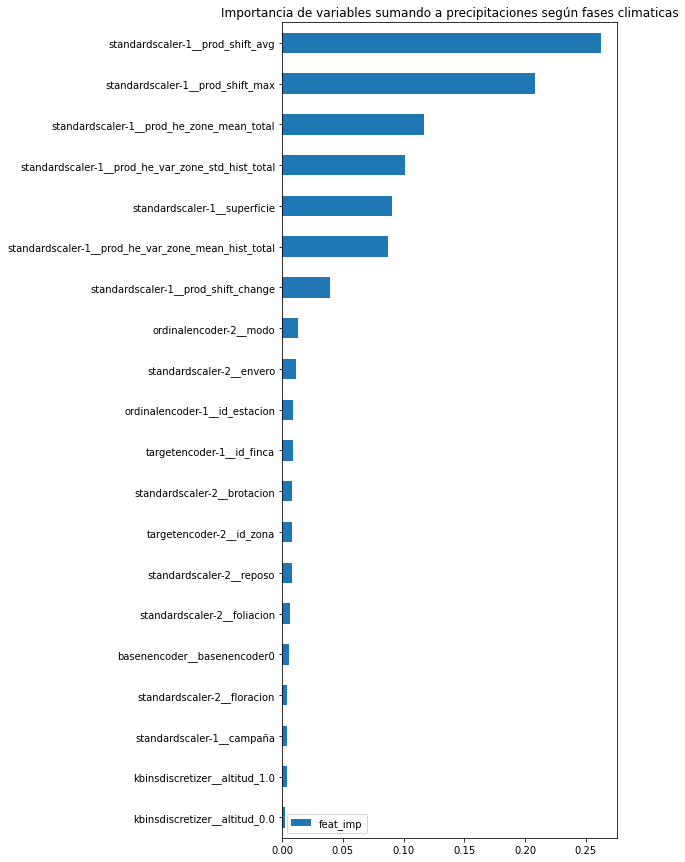

In [533]:
show_feat_imps(
    m[-1].feature_importances_,
    m[:-1].get_feature_names_out(),
)

plt.title('Importancia de variables sumando a precipitaciones según fases climaticas')
plt.show()


## Modelos

In [491]:
data_train = tr.filter_camp(data.copy(), min_camp=15, max_camp=21)

data_final = tr.filter_camp(data, min_camp=22, max_camp=22)

train, test = tr.train_test_split(data_train, test_camp=21)

X, y = tr.xy_split(data_train)

cat_cols = [
    'id_finca',
    'id_zona',
    'id_estacion',
    'variedad',
    "modo",
    "tipo",
    "color",
    "prod_shift1_gt_shift2",
    "sup_is_nan",
]
num_cols = [col for col in X.columns if col not in cat_cols]

X[cat_cols] = X[cat_cols].astype('category')

X_train, y_train = tr.xy_split(train)
X_test, y_test = tr.xy_split(test)
X_final, y_final = tr.xy_split(data_final)

train_idxs, test_idxs = tr.CampKFold.get_train_test(
    X['campaña'], from_camp=19, to_camp=21
)

cv = tr.CampKFold(train_idxs, test_idxs)


In [492]:
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder, StandardScaler, LabelEncoder
import pickle as pkl
from typing import List
import malbecs.modeling.transformers as mt

seed = 42

from sklearn.decomposition import PCA


def get_preprocesing():

    model_num_cols = [
        'campaña',
        'superficie',
        'prod_shift_max',
        'prod_shift_change',
        'prod_shift_avg',
        #'prod_he_var_zone_mean_hist_total',
        #'prod_he_var_zone_std_hist_total',
        #'prod_he_zone_mean_total',
    ]

    return make_column_transformer(

        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['sup_is_nan']),
        (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['id_finca']),
        (mt.TargetEncoder(), ['id_zona']),
        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['id_zona']),
        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['variedad']),
        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['modo']),
        (StandardScaler(), model_num_cols),
        remainder='drop'
    )



In [493]:
prep = get_preprocesing()

model = RandomForestRegressor(
    random_state=seed,
    n_estimators=500,
    min_samples_leaf=4,
    n_jobs=-1,
    max_features=0.20,
    max_samples=0.8
)


m = make_pipeline(
    prep,
    model
)


In [494]:
from sklearn.model_selection import cross_validate
import numpy as np

res = cross_validate(
    estimator=m,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True
)

print("train: ", res['train_score'])
print("test: ", res['test_score'])
print(f"Train Mean RMSE: {np.mean(res.get('train_score'))}")
print(f"Test Mean RMSE: {np.mean(res.get('test_score'))}")

train:  [-4963.91024668 -4731.56323177 -4753.27924972]
test:  [-4840.96717912 -6646.71974138 -5334.82890183]
Train Mean RMSE: -4816.250909391128
Test Mean RMSE: -5607.505274113994


Columnas climtaicas para PCA

In [495]:
percip_cols = [c for c in eto_cols if "Precip" in c]
snow_cols = [c for c in eto_cols if "Snow" in c]
temp_day_cols = [c for c in eto_cols if "TemperatureLocalDay" in c]
temp_cols = [
    c for c in eto_cols if "TemperatureLocalAfter" in c or "TemperatureLocalOvern" in c]
evotrans_cols = [c for c in eto_cols if "Evapotranspiration" in c]
feelslike_cols = [c for c in eto_cols if "FeelsLikeLoca" in c]
irrad_cols = [c for c in eto_cols if "Irradiance" in c]
gust_cols = [c for c in eto_cols if "Gust" in c]
wind_cols = [c for c in eto_cols if "Wind" in c]
dewpoint_cols = [c for c in eto_cols if "Dewpoint" in c]
mslp_cols = [c for c in eto_cols if "MSLP" in c]
humid_cols = [c for c in eto_cols if "Humidity" in c]
uvindex_cols = [c for c in eto_cols if "UVIndex" in c]
visib_cols = [c for c in eto_cols if "Visibility" in c]


In [496]:
n_fincas = X['id_finca'].nunique()
top_fincas = X.id_finca.value_counts()[:int(0.8*n_fincas)].index.values.tolist()
X['id_finca_top'] = X['id_finca'].apply(lambda x: x if x in top_fincas else -1)

n_zonas = X['id_zona'].nunique()
top_zonas = X['id_zona'].value_counts()[:int(0.8*n_zonas)].index.values.tolist()
X['id_zona_top'] = X['id_zona'].apply(lambda x: x if x in top_zonas else -1)

n_var = X['variedad'].nunique()
top_variedad= X['variedad'].value_counts()[:int(0.8*n_var)].index.values.tolist()
X['variedad_top'] = X['variedad'].apply(
    lambda x: x if x in top_variedad else -1)


In [497]:
from sklearn.decomposition import PCA

cols_pca = [c for c in gust_cols if 'Max' in c]
pca = make_pipeline(StandardScaler(),PCA(random_state=seed))


Xt = pca.fit_transform(X[cols_pca])


#### Modelo nuevo - PCAs temp + nuevas producciones segun otras variables + flags

In [498]:
data_train = tr.filter_camp(data.copy(), min_camp=15, max_camp=21)

data_final = tr.filter_camp(data, min_camp=22, max_camp=22)

train, test = tr.train_test_split(data_train, test_camp=21)

X, y = tr.xy_split(data_train)

cat_cols = [
    'id_finca',
    'id_zona',
    'id_estacion',
    'variedad',
    "modo",
    "tipo",
    "color",
    "prod_shift1_gt_shift2",
    "sup_is_nan",
]
num_cols = [col for col in X.columns if col not in cat_cols]

X[cat_cols] = X[cat_cols].astype('category')

X_train, y_train = tr.xy_split(train)
X_test, y_test = tr.xy_split(test)
X_final, y_final = tr.xy_split(data_final)

train_idxs, test_idxs = tr.CampKFold.get_train_test(
    X['campaña'], from_camp=19, to_camp=21
)

cv = tr.CampKFold(train_idxs, test_idxs)


In [499]:
X['sup_flag'] = [1 if x == -1 else 0 for x in X.sup_shift1] 
X['shift_flag'] = [1 if x == -1 else 0 for x in X.prod_shift1] 
flag_cols = ['sup_flag','shift_flag']

In [500]:
from sklearn.decomposition import PCA


def get_preprocesing():

    model_num_cols = [
        'campaña',
        'superficie',
        'prod_shift_max',
        'prod_shift_change',
        'prod_shift_avg',
        'prod_he_var_zone_mean_hist_total',
        'prod_he_var_zone_std_hist_total',
        'prod_he_zone_mean_total',
    ]

    return make_column_transformer(

        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['sup_is_nan']),
        (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['id_finca']),
        (mt.TargetEncoder(), ['id_zona']),
        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['id_zona']),
        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['variedad']),
        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['modo']),
        (StandardScaler(), model_num_cols),
        (OrdinalEncoder(), flag_cols),
        (make_pipeline(StandardScaler(),PCA(n_components=2, random_state=seed)),
             [c for c in percip_cols if 'Sum' in c]
        ),
        (StandardScaler(),[c for c in snow_cols if 'Sum' in c and ("1" in c or "2" in c)]),
        (make_pipeline(StandardScaler(),PCA(n_components=2, random_state=seed)), [c for c in gust_cols if 'Max' in c ]),
        
        remainder='drop'
    )


In [501]:
from sklearn.ensemble import StackingRegressor, VotingRegressor

prep = get_preprocesing()

model = RandomForestRegressor(
    random_state=seed,
    n_estimators=500,
    min_samples_leaf=4,
    n_jobs=-1,
    max_features=0.20,
    max_samples=0.8
)


m = make_pipeline(
    prep,
    model
)


In [502]:
res = cross_validate(
    estimator=m,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True,
    fit_params={
    }
)


print("train: ", res['train_score'])
print("test: ", res['test_score'])
print(f"Train Mean RMSE: {np.mean(res.get('train_score'))}")
print(f"Test Mean RMSE: {np.mean(res.get('test_score'))}")

train:  [-4691.34941669 -4444.04995327 -4482.43823288]
test:  [-4774.56248763 -6646.44459356 -5376.8593553 ]
Train Mean RMSE: -4539.2792009451905
Test Mean RMSE: -5599.288812164074


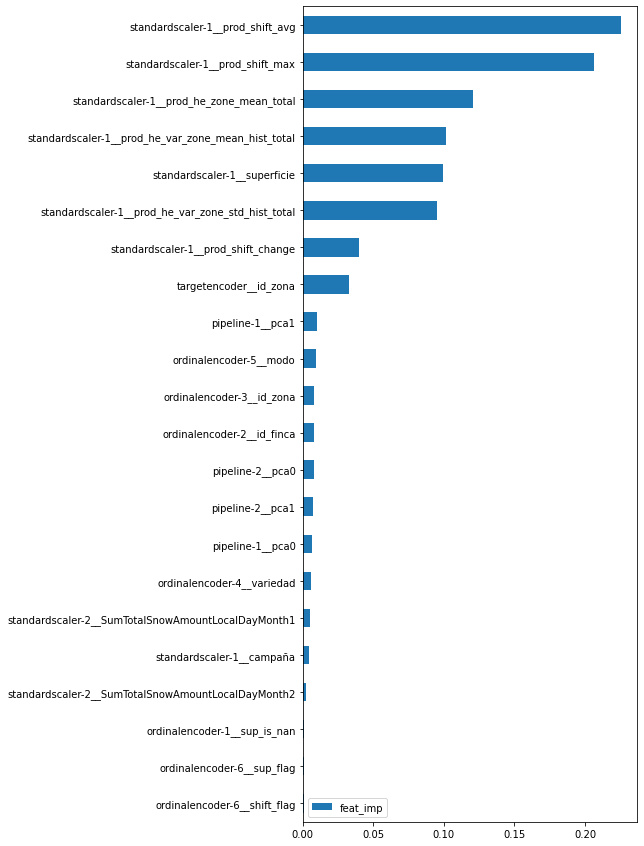

In [503]:
m.fit(X,y)
show_feat_imps(
    m[-1].feature_importances_,
    m[:-1].get_feature_names_out(),
)


#### Comparar predicciones modelo nuevo vs original

In [80]:
#Originales

df_preds = pd.read_csv('../../data/final/Malbecs.txt',sep='|',header=None)
preds_originales = df_preds[6]

In [81]:
x_test_v2 = data_final.drop(columns=['produccion'])

In [82]:
preds_nuevas = m.predict(x_test_v2)

In [85]:
preds_final_2 = data_final[['id_finca', 'variedad','modo','tipo','color','superficie']].copy()
preds_final_2['produccion'] = preds_nuevas
preds_final_2 = preds_final_2.sort_values(['id_finca', 'variedad','modo','tipo','color','superficie'], ascending=True)

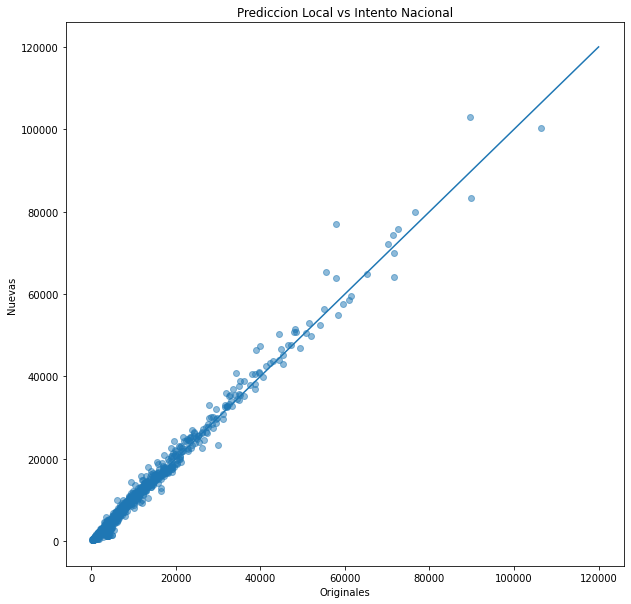

In [86]:
plt.figure(figsize=(10,10))
plt.scatter(preds_originales, preds_final_2['produccion'], alpha=0.5)
plt.plot( [0,120000],[0,120000] )
plt.xlabel('Originales')
plt.ylabel('Nuevas')
plt.title('Prediccion Local vs Intento Nacional')
plt.show()

In [87]:
preds_final_2.to_csv('../../data/final/UH2023_Universidad Complutense de Madrid (UCM)_Malbecs_2.txt', sep="|", header=None, index=False)

#### Comparar predicciones modelo original + clima vs original

In [38]:
#Originales

df_preds = pd.read_csv('../../data/final/Malbecs.txt',sep='|',header=None)
preds_originales = df_preds[6]

In [60]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, HuberRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder, StandardScaler
import pickle as pkl
from typing import List
import malbecs.modeling.transformers as mt

seed = 42

def get_base_model_v2():

    model_num_cols = [
        'superficie',
        'prod_shift_max',
        'prod_shift_change',
        'prod_shift_avg',
    ]

    m = make_pipeline(
        make_column_transformer(

            (mt.BaseNEncoder(), ['id_finca']),

            (mt.TargetEncoder(), ['id_zona']),

            (OrdinalEncoder(handle_unknown='use_encoded_value',
             unknown_value=-1), ['id_estacion']),

            (mt.BaseNEncoder(), ['variedad']),

            (OrdinalEncoder(handle_unknown='use_encoded_value',
             unknown_value=-1), ['modo']),

            (KBinsDiscretizer(n_bins=2), ['altitud']),

            (StandardScaler(), model_num_cols),

            (make_pipeline(StandardScaler(),PCA(n_components=2, random_state=seed)),[c for c in percip_cols if 'Sum' in c]),
            
            (StandardScaler(),[c for c in snow_cols if 'Sum' in c and ("1" in c or "2" in c)]),

            remainder='drop'
        ),
        RandomForestRegressor(
            random_state=seed,
            n_estimators=200,
            min_samples_leaf=4,
            n_jobs=-1,
            max_features='sqrt',
            max_samples=0.8
        )
    )
    return m


In [61]:
m_nuevo = get_base_model_v2()
res = cross_validate(
    estimator=m_nuevo,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True,
    fit_params={
        # "randomforestregressor__sample_weight": sample_weight
        # "stackingregressor__sample_weight": sample_weight
    }
)


print("train: ", res['train_score'])
print("test: ", res['test_score'])
print(f"Train Mean RMSE: {np.mean(res.get('train_score'))}")
print(f"Test Mean RMSE: {np.mean(res.get('test_score'))}")

train:  [-4727.2469563  -4541.35514995 -4601.38580505]
test:  [-4867.83389351 -6638.79785759 -5433.38564627]
Train Mean RMSE: -4623.329303766486
Test Mean RMSE: -5646.672465790679


In [62]:
m_nuevo = get_base_model_v2()
m_nuevo.fit(X,y)
preds_nuevas = m_nuevo.predict(x_test_v2)

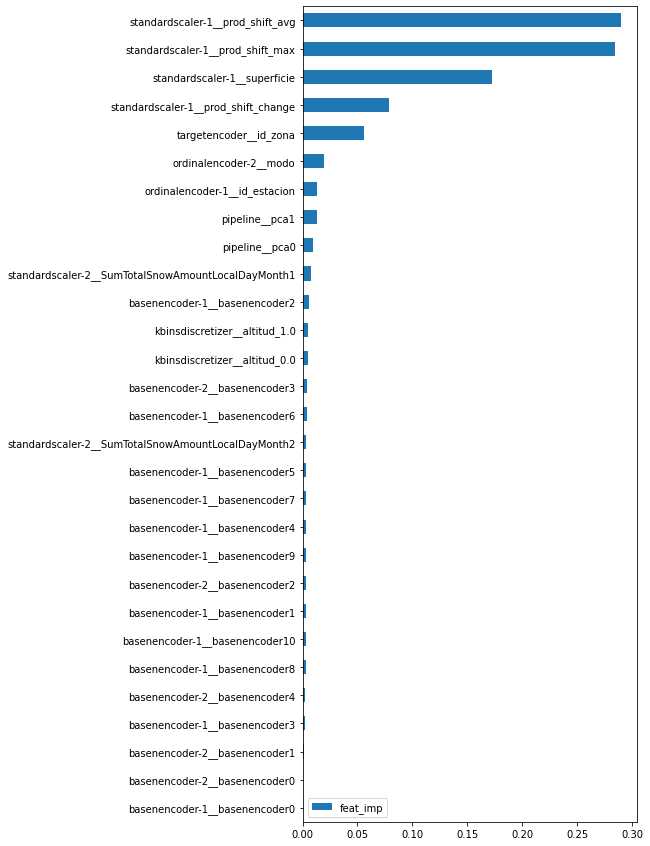

In [63]:
show_feat_imps(
    m_nuevo[-1].feature_importances_,
    m_nuevo[:-1].get_feature_names_out(),
)


In [66]:
preds_final_v2 = data_final[['id_finca', 'variedad','modo','tipo','color','superficie']].copy()
preds_final_v2['produccion'] = preds_nuevas
preds_final_v2 = preds_final_v2.sort_values(['id_finca', 'variedad','modo','tipo','color','superficie'], ascending=True)

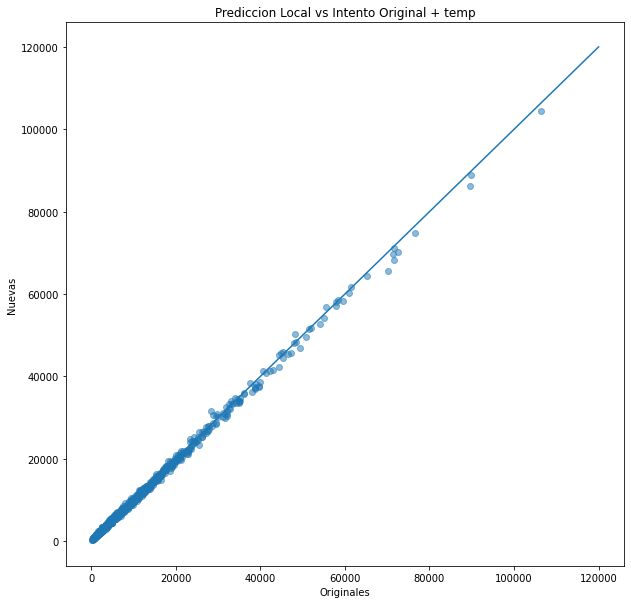

In [68]:
plt.figure(figsize=(10,10))
plt.scatter(preds_originales, preds_final_v2['produccion'], alpha=0.5)
plt.plot( [0,120000],[0,120000] )
plt.xlabel('Originales')
plt.ylabel('Nuevas')
plt.title('Prediccion Local vs Intento Original + temp')
plt.show()

In [67]:
preds_final_v2

,id_finca,variedad,modo,tipo,color,superficie,produccion
9498,439,9,2,0,0,1.0800,3847.994307
8923,447,40,2,0,1,0.4694,2647.855934
8602,523,32,2,0,1,0.6478,2093.686110
9242,702,59,2,0,1,1.1331,8143.693395
8750,797,59,1,0,1,7.5143,12131.850378
...,...,...,...,...,...,...,...
9236,99282,59,2,0,1,1.6244,7611.700026
9117,99377,52,2,0,1,0.6500,2458.847053
9320,99693,81,1,0,1,6.3397,28641.610416
9036,99793,52,2,0,1,0.1326,4068.094352


In [72]:
preds_final_v2.to_csv('../../data/final/UH2023_Universidad Complutense de Madrid (UCM)_Malbecs_1.txt', sep="|", header=None, index=False)

### Comparo con el de fases climaticas

In [534]:
#Originales

df_preds = pd.read_csv('../../data/final/Malbecs.txt',sep='|',header=None)
preds_originales = df_preds[6]

In [535]:
X_train = data_train_eto[data_train_eto.campaña<21].drop(columns='produccion')
X_test = data_train_eto[data_train_eto.campaña==21].drop(columns='produccion')
y_train = data_train_eto[data_train_eto.campaña<21]['produccion']
y_test = data_train_eto[data_train_eto.campaña==21]['produccion']

def get_base_model_v3():

    model_num_cols = [
        'campaña',
        'superficie',
        'prod_shift_max',
        'prod_shift_change',
        'prod_shift_avg',
        'prod_he_var_zone_mean_hist_total',
        'prod_he_var_zone_std_hist_total',
        'prod_he_zone_mean_total',
    ]

    m = make_pipeline(
        make_column_transformer(

            (mt.TargetEncoder(), ['id_finca']),

            (mt.TargetEncoder(), ['id_zona']),

            (OrdinalEncoder(handle_unknown='use_encoded_value',
             unknown_value=-1), ['id_estacion']),

            (mt.BaseNEncoder(), ['variedad']),

            (OrdinalEncoder(handle_unknown='use_encoded_value',
             unknown_value=-1), ['modo']),

            (KBinsDiscretizer(n_bins=2), ['altitud']),

            (StandardScaler(), model_num_cols),

            (StandardScaler(), fases), #ACA ESTA LO NUEVO

            remainder='drop'
        ),
        RandomForestRegressor(
            random_state=seed,
            n_estimators=200,
            min_samples_leaf=4,
            n_jobs=-1,
            max_features='sqrt',
            max_samples=0.8
        )
    )
    return m

In [536]:
data_final_eto = data_eto[data_eto.campaña==22]

In [537]:
x_test_v3 = data_final_eto.drop(columns=['produccion'])

In [538]:
X_eto = data_eto[(data_eto.campaña<22)&(data_eto.campaña>14) ].drop(columns='produccion')
y_eto = data_eto[(data_eto.campaña<22)&(data_eto.campaña>14) ]['produccion']

In [539]:
m_nuevo = get_base_model_v3()
m_nuevo.fit(X_eto,y_eto)
preds_nuevas = m_nuevo.predict(x_test_v3)

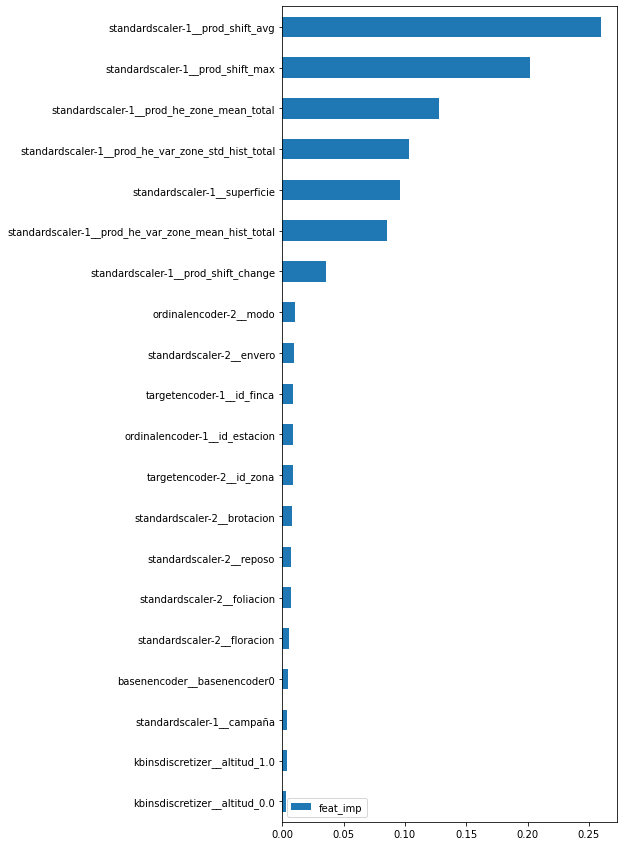

In [540]:
show_feat_imps(
    m_nuevo[-1].feature_importances_,
    m_nuevo[:-1].get_feature_names_out(),
)


In [541]:
preds_final_v2 = data_final_eto[['id_finca', 'variedad','modo','tipo','color','superficie']].copy()
preds_final_v2['produccion'] = preds_nuevas
preds_final_v2 = preds_final_v2.sort_values(['id_finca', 'variedad','modo','tipo','color','superficie'], ascending=True)

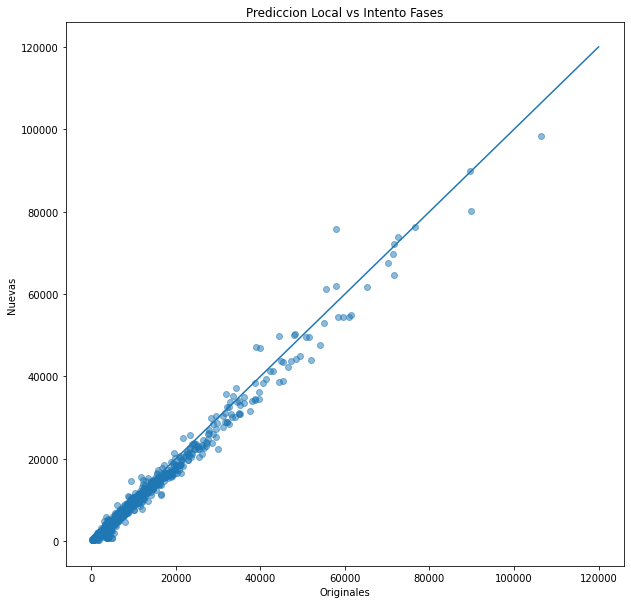

In [547]:
plt.figure(figsize=(10,10))
plt.scatter(preds_originales, preds_final_v2['produccion'], alpha=0.5)
plt.plot( [0,120000],[0,120000] )
plt.xlabel('Originales')
plt.ylabel('Nuevas')
plt.title('Prediccion Local vs Intento Fases')
plt.show()

In [544]:
preds_final_v2.to_csv('../../data/final/UH2023_Universidad Complutense de Madrid (UCM)_Malbecs_3.txt', sep="|", header=None, index=False)

In [545]:
#Originales

df_preds_2 = pd.read_csv('../../data/final/UH2023_Universidad Complutense de Madrid (UCM)_Malbecs_2.txt',sep='|',header=None)
preds_intento_2 = df_preds_2[6]
preds_intento_2

0        3505.411019
1        2440.491113
2        1854.536694
3        6091.124450
4       13090.084198
            ...     
1070     8121.095527
1071     3015.089955
1072    30078.219488
1073     1432.468323
1074     1424.320628
Name: 6, Length: 1075, dtype: float64

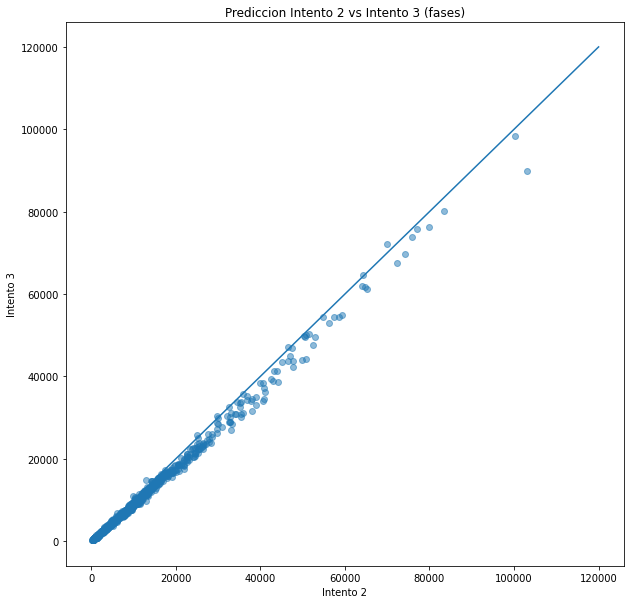

In [546]:
plt.figure(figsize=(10,10))
plt.scatter(preds_intento_2, preds_final_v2['produccion'], alpha=0.5)
plt.plot( [0,120000],[0,120000] )
plt.xlabel('Intento 2')
plt.ylabel('Intento 3')
plt.title('Prediccion Intento 2 vs Intento 3 (fases)')
plt.show()